# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/image_captioning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [ ]:
!pip install einops==0.7.0 tensorflow_text==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.1 MB/s eta 0:00:00


This tutorial uses lots of imports, mostly for loading the dataset(s).

In [ ]:
# @title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Choose a dataset

This tutorial is set up to give a choice of datasets. Either [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) or a small slice of the [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset. These two are downloaded and converted from scratch, but it wouldn't be hard to convert the tutorial to use the caption datasets available in [TensorFlow Datasets](https://www.tensorflow.org/datasets): [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) and the full [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions).


#### Flickr30k

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/MyDrive/MyDrive/data/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download hsankesara/flickr-image-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.16G/8.16G [01:03<00:00, 212MB/s]
100% 8.16G/8.16G [01:03<00:00, 139MB/s]


In [ ]:
# prompt: unzip /content/flickr-image-dataset.zip to /content/flickr-image-dataset/

!unzip /content/flickr-image-dataset.zip -d /content/flickr-image-dataset/
!rm /content/flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: /content/flickr-image-dataset/flickr30k_images/flick

In [ ]:
# Path to the images
IMAGES_PATH = "/content/flickr-image-dataset/flickr30k_images/flickr30k_images"
# Path to the captions
CAPTIONS_PATH = "/content/flickr-image-dataset/flickr30k_images/results.csv"
from sklearn.model_selection import train_test_split

# Fixed length allowed for any sequence
SEQ_LENGTH = 24
# Loads captions (text) data and maps them to corresponding images.
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:]
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Each image is repeated five times for the five different captions.
            # Image name and captions are separated using a comma
            try:
                img_name, _, caption = line.split("| ")
                # There is one row in the dataset which causes ValueError when splitting.
                # Handling the error:
            except ValueError:
                img_name, caption = line.split("| ")
                caption = caption[4:]

            img_name = os.path.join(IMAGES_PATH, img_name.strip())
            # Removing caption that are either too short to too long
            tokens = caption.strip().split()
            if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # A start and an end token must be added to each caption
#                 caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption.strip())

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

def train_val_split(caption_data, test_size=0.2, shuffle=True):
    # Getting the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    train_keys, test_keys = train_test_split(all_images, test_size=test_size, random_state=42)

#     training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    train_data = [(str(img_name),caption_data[img_name]) for img_name in  train_keys]
#     test_data = {img_name: caption_data[img_name] for img_name in test_keys}
    test_data = [(str(img_name),caption_data[img_name]) for img_name in  test_keys]

    train_ds = tf.data.experimental.from_list(train_data)
    test_ds = tf.data.experimental.from_list(test_data)

    # Return the splits
    return train_ds, test_ds



# Loading the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Spliting the dataset
train_raw, test_raw = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")


Total number of samples: 26144


In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/flickr-image-dataset/flickr30k_images/flickr30k_images/4656715193.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A motorcycle driver in a pink and white suit is stretched in an awkward position .'
 b'A motorbike racing sitting on a white , pink , blue , and green motorbike .'
 b'a motorcycle racer in a blue and pink suit getting ready to race .'
 b'A motorcyclist is wearing a pink and blue racing suit .'
 b'this is a motorcycle race .'], shape=(5,), dtype=string)


In [ ]:
num_images = 0
for ex_path, ex_captions in train_raw.as_numpy_iterator():
    num_images += 1
print(num_images)

20915


In [ ]:
num_images = 0
for ex_path, ex_captions in test_raw.as_numpy_iterator():
    num_images += 1
print(num_images)

5229


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [ ]:
import tensorflow as tf

IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Large(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
    include_preprocessing=True)
mobilenet.trainable=False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
mobilenet.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

Here's a function to load an image and resize it for the model:

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    img = tf.image.convert_image_dtype(img, tf.float32) # input: float -> (0, 1) || input: int -> (0, 255)
    return img # (0, 255)
    # return img / 255.0 # (0, 1)

In [ ]:
test_img_batch = load_image(IMAGES_PATH+"/1007320043.jpg")[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape) # (1, 7, 7, 960)

(1, 224, 224, 3)
(1, 7, 7, 960)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 10000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'man', 'is']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 704, 5, 2, 69, 4], [3, 2, 3506, 26, 4]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

In [ ]:
word_to_index('cat').numpy()

704

In [ ]:
word_to_index('.').numpy() # [UNK]

1

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs.

This function will replicate the image so there are 1:1 images to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
def prepare_txt(imgs, txts):
  txts = tf.reshape(txts, [-1])
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
num_batches = 0
for (img, pre_cap), cap in train_ds.as_numpy_iterator():
    num_batches += 1
print(num_batches) # 6000 * num_cap_per_img(5) / batch_size(32) = 3268

3268


In [ ]:
num_batches = 0
for (img, pre_cap), cap in test_ds.as_numpy_iterator():
    num_batches += 1
print(num_batches) # 1000 * num_cap_per_img(5) / batch_size(32)  = 818

818


In [ ]:
for (img, pre_cap), cap in train_ds.take(1):
    break

print('image paths:', img.shape)
print('pre-captions:', pre_cap.shape)
print('captions:', cap.shape)

image paths: (32, 224, 224, 3)
pre-captions: (32, 21)
captions: (32, 21)


### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`:

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [01:04,  2.89it/s]
32it [00:09,  3.25it/s]


## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 22)
(32, 22)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2   8  35 117   5  40  11   2  83   0   0   0   0   0   0   0   0
   0   0   0   0]
[  2   8  35 117   5  40  11   2  83   4   0   0   0   0   0   0   0   0
   0   0   0   0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs.

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer): # or PositionalEmbedding
  def __init__(self, vocab_size, max_length, depth, pretrained_embedding=None): # depth or embeb_size
    super().__init__()
    self.vocab_size = vocab_size
    self.depth = depth
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    if pretrained_embedding is not None:
      self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        weights=[pretrained_embedding],
        trainable=False,  # Freeze pretrained embeddings
        mask_zero=True)
    else:
      self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`,
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well.

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3268it [03:29, 15.58it/s]


Uniform entropy: 9.21
Marginal entropy: 5.56


### Embedding word using Glove

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!mkdir glove
!unzip glove.6B.zip -d glove

In [ ]:
glove_dir = '/content/glove/'
file = open(glove_dir + 'glove.6B.300d.txt', encoding="utf-8")

i = 0
for line in file:
    print(line)
    i+= 1
    if i > 5:
        break

In [ ]:
import numpy as np

glove_dir = '/content/glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.300d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embeddings_index['girl'].shape

In [ ]:
tokenizer.vocabulary_size()

In [ ]:
embed_size = 300 # glove 300-D

# Get 300-dim dense vector for each of the 7634 words in out vocabulary
embedding_matrix = np.zeros((tokenizer.vocabulary_size(), embed_size))

for i, word in enumerate(word_to_index.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

In [ ]:
from pickle import dump, load
with open("/content/MyDrive/MyDrive/model/XLA/flicker30k/embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

### Build the model

In [ ]:
from pickle import dump, load

embedding_matrix = load(open("/content/MyDrive/MyDrive/model/XLA/flicker30k/embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(10000, 300)

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer`.
1. The `seq_embedding` layer, to convert batches of token-IDs to
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, pretrained_embedding,
               num_layers=1, units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=embed_size,
        max_length=max_length,
        pretrained_embedding=pretrained_embedding)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply random flip
      image = tf.image.random_flip_left_right(image)
      # Apply random contrast
      image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
      # Apply random brightness
      image = tf.image.random_brightness(image, max_delta=0.2)
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [ ]:
# model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
#                   units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
embed_size = 300 # glove
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer, pretrained_embedding=embedding_matrix,
                  units=embed_size, dropout_rate=0.5, num_layers=4, num_heads=12)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 1us/step


To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
max_seq_len = 50

@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(max_seq_len):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a

an of children a rides race in giving a the sloping socks a running


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`).

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a in a in
a with a woman ladies in river



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`.

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2738 - masked_acc: 0.1894

a man in a man in a man in a man in a man
a man in a man in a black
a wearing water on ground

100/100 [==============================] - 63s 367ms/step - loss: 5.2738 - masked_acc: 0.1894 - val_loss: 4.9847 - val_masked_acc: 0.2307
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.9005 - masked_acc: 0.2389

a man in a white shirt is in a a white
a man in a red is is in a
a baby watching back a shirtless across sunglasses racing

100/100 [==============================] - 30s 298ms/step - loss: 4.9005 - masked_acc: 0.2389 - val_loss: 4.7569 - val_masked_acc: 0.2480
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.7246 - masked_acc: 0.2564

a man in a white shirt is in a white shirt is is in a water
a man in a woman is playing a red with a white shirt in a red shirt
a man and a the dirt

100/100 [==============================] - 30s 299ms/st

Plot the loss and accuracy over the training run:

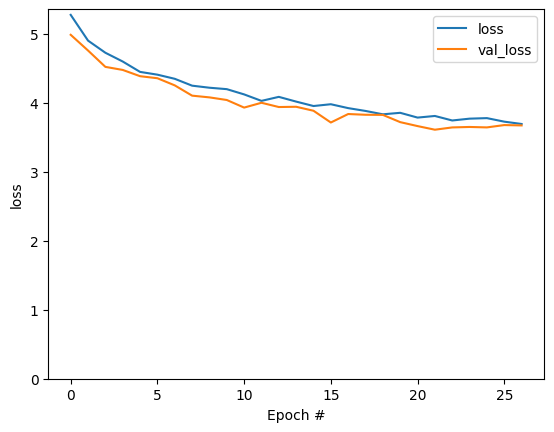

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.legend()

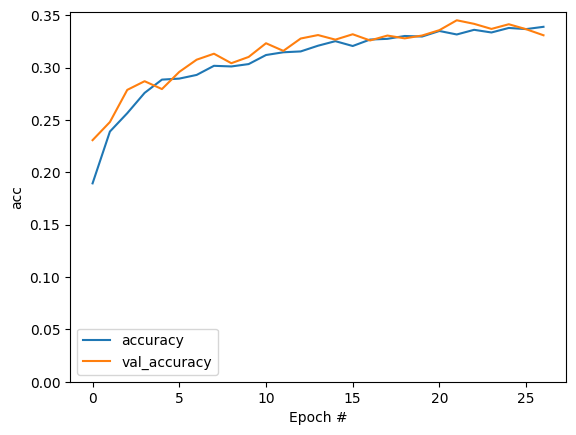

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('acc')
plt.legend()

(0.0, 5.3570533990859985)

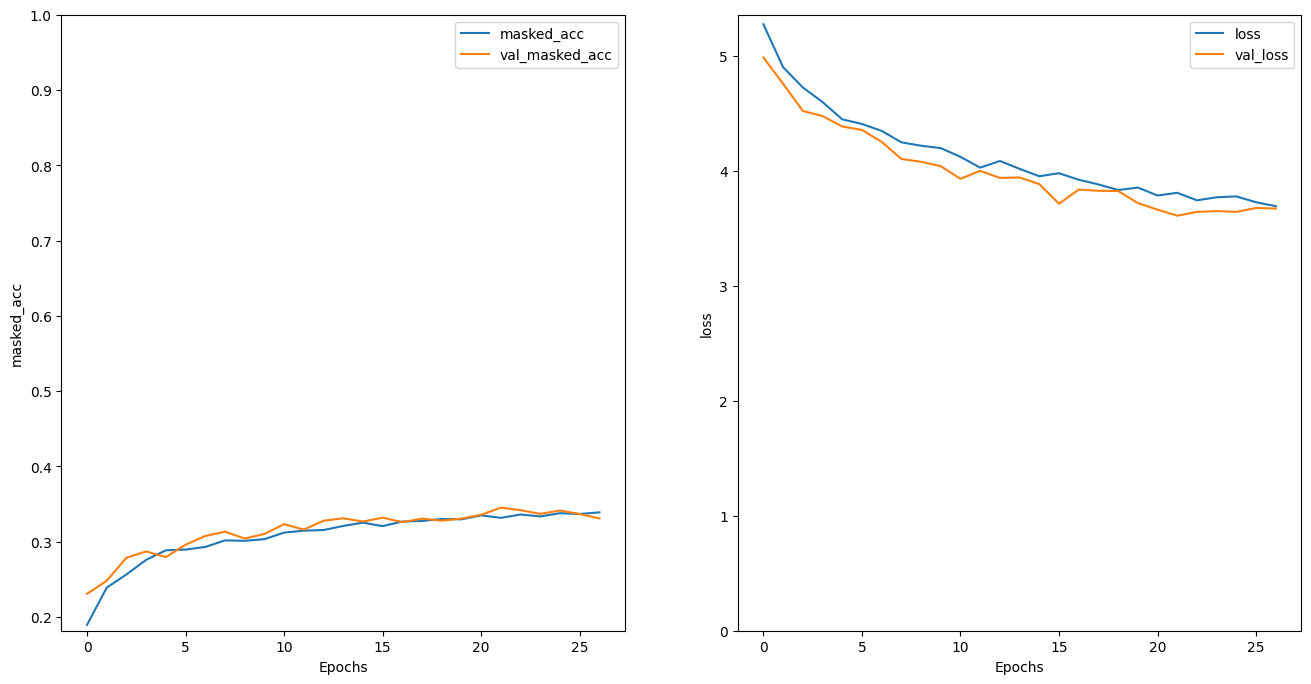

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'masked_acc')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Save trained model

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
# Lưu model
model.save_weights('/content/MyDrive/MyDrive/Colab Notebooks/Image captioning/tensorflow/saved_model.ckp') #, save_format='tf')

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red wetsuit is surfing a wave'

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')
str_tokens

['a',
 'man',
 'in',
 'a',
 'red',
 'wetsuit',
 'is',
 'surfing',
 'a',
 'wave',
 '[END]']

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 12, 11, 49]),
 TensorShape([1, 12, 11, 49]),
 TensorShape([1, 12, 11, 49]),
 TensorShape([1, 12, 11, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

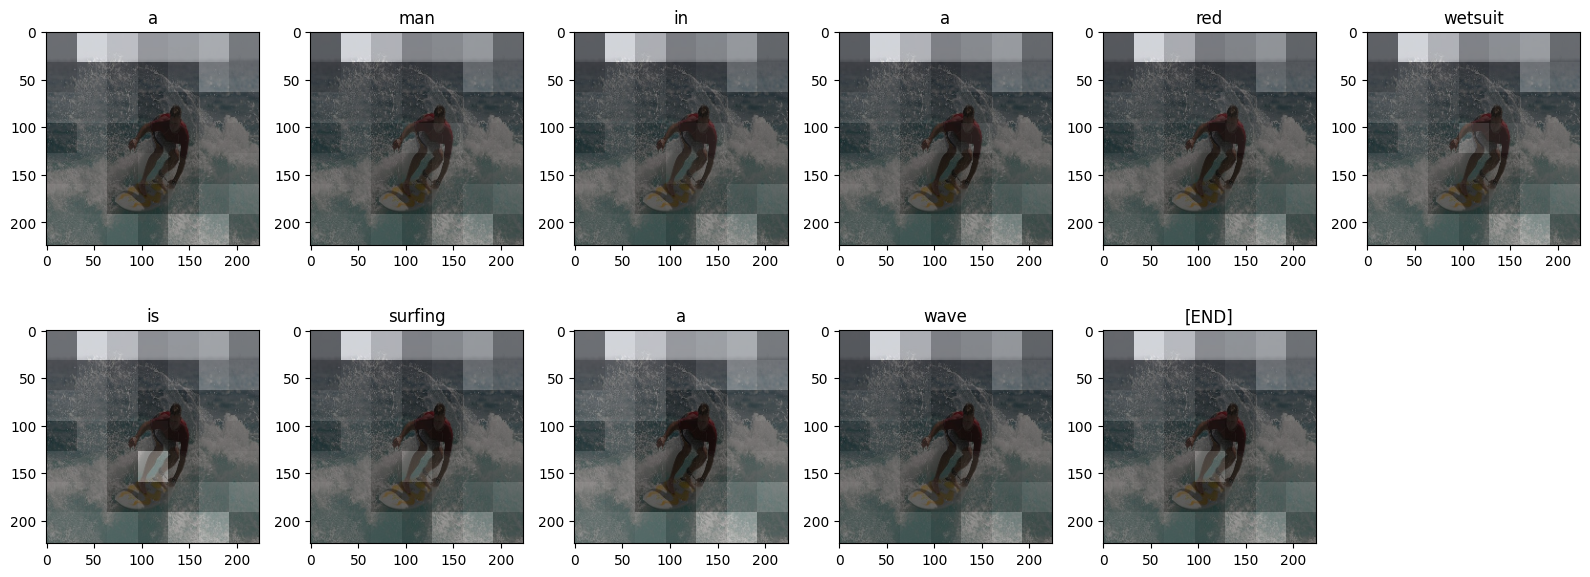

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


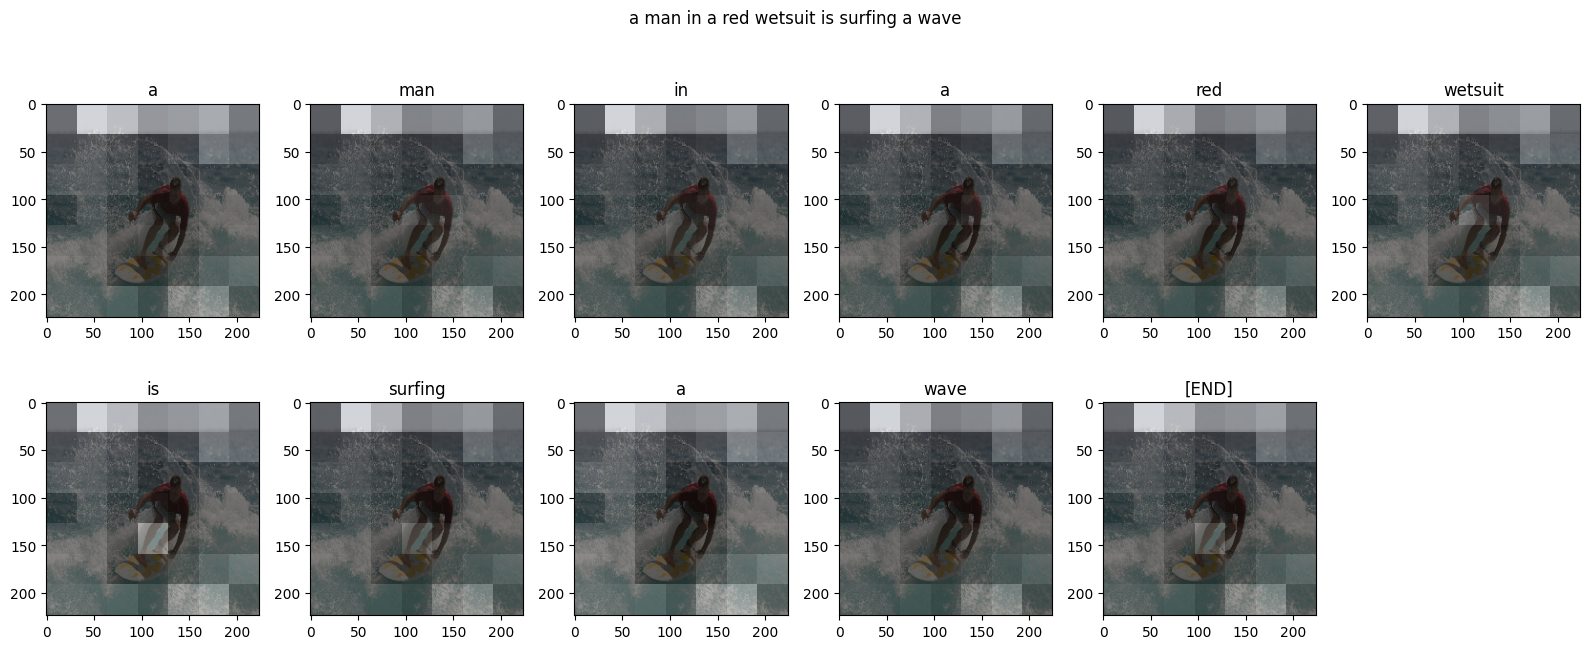

In [ ]:
run_and_show_attention(model, image, temperature=0.0)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


67460/67460 [==============================] - 0s 0us/step


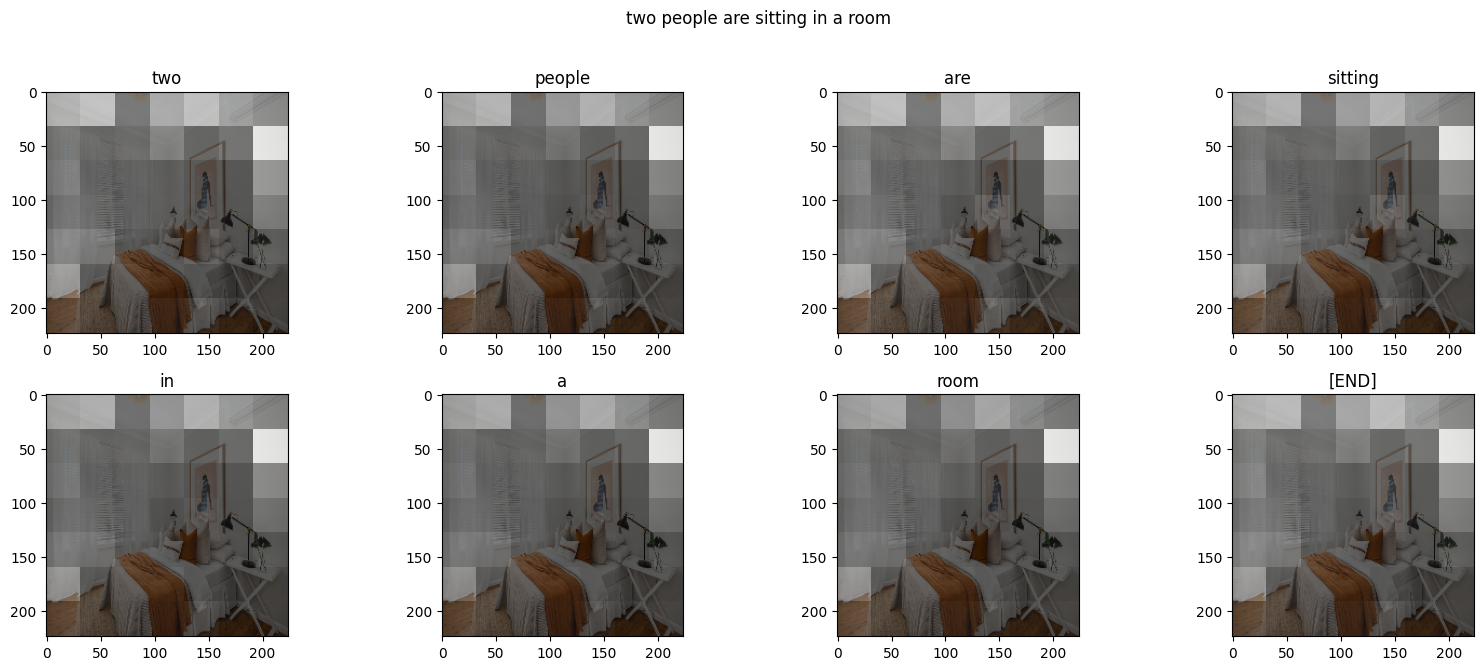

In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

## Load model and predict

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
embed_size = 300 # glove
new_model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer, pretrained_embedding=embedding_matrix,
                  units=embed_size, dropout_rate=0.5, num_layers=4, num_heads=12)
new_model.load_weights('/content/MyDrive/MyDrive/model/XLA/flicker30k/saved_model/saved_model.ckp')

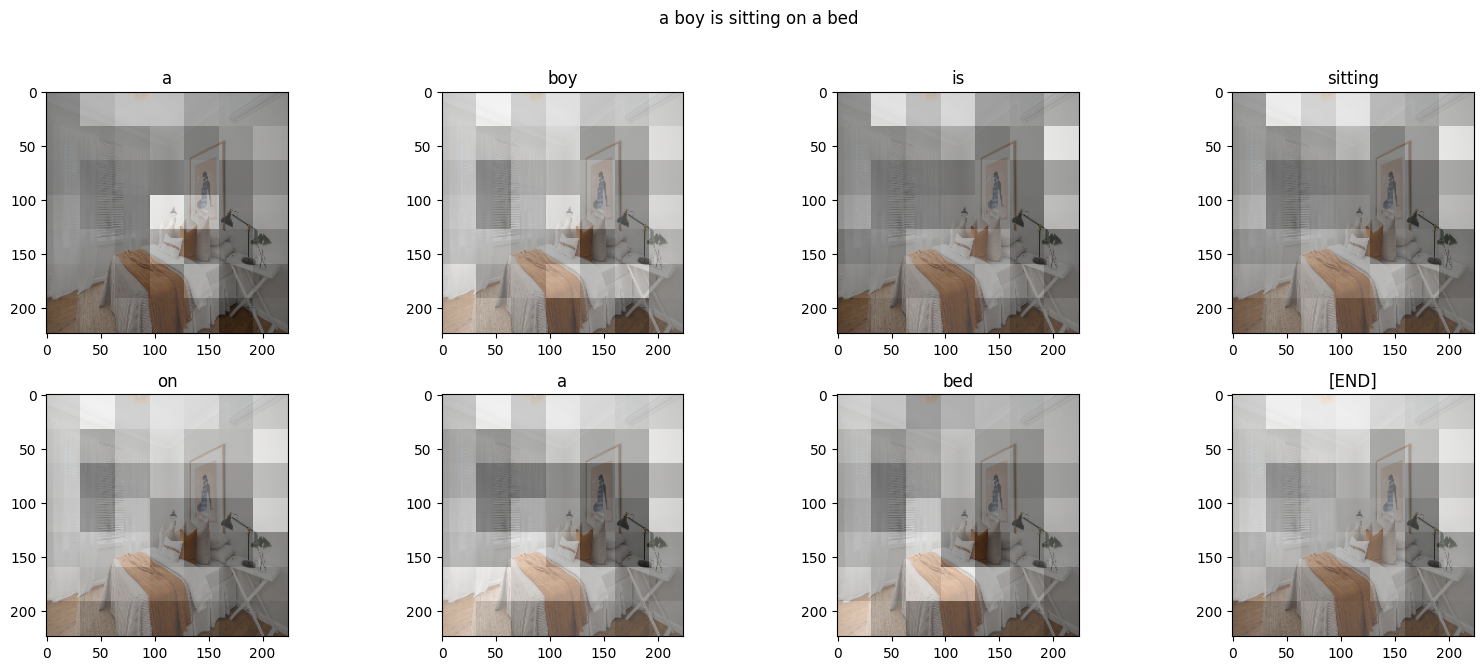

In [ ]:
def run_and_show_attention(image, temperature=0.0):
  result_txt = new_model.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in new_model.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)
run_and_show_attention(image)

## Check sample predictions

In [ ]:
import tensorflow as tf

# Function to filter the dataset based on image file path
def filter_dataset(image_path, dataset):
    filtered_dataset = dataset.filter(lambda x, y: tf.equal(x, image_path))
    return filtered_dataset

# Function to extract captions from the filtered dataset
def get_captions(image_path, dataset):
    filtered_dataset = filter_dataset(image_path.encode("utf-8"), dataset)
    captions = [caption.numpy().decode("utf-8") for _, captions in filtered_dataset for caption in captions]
    return captions

# Example usage
image_path = '/content/flickr-image-dataset/flickr30k_images/flickr30k_images/1000523639.jpg'
captions = get_captions(image_path, train_raw)
print("Captions for image", image_path, ":\n", captions)

Captions for image /content/flickr-image-dataset/flickr30k_images/flickr30k_images/1000523639.jpg :
 ['Two people in the photo are playing the guitar and the other is poking at him .', 'A man in green holds a guitar while the other man observes his shirt .', 'A man is fixing the guitar players costume .', "a guy stitching up another man 's coat .", 'the two boys playing guitar']


In [ ]:
def split_caption(captions):
    result = []
    for caption in captions:
        text = caption.lower()
        text = text.split(' ')
        text = [i for i in text if word_to_index(i).numpy() != 1] # [UNK]
        result.append(text)
    return result
image_path = 'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg'
captions = get_captions(image_path, train_raw)
print("Captions for image", image_path, ":\n", split_caption(captions))

Captions for image flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg :
 []


In [ ]:
train_paths = [element[0].numpy().decode("utf-8") for element in list(train_raw)]
test_paths = [element[0].numpy().decode("utf-8") for element in list(test_raw)]

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

def generate_caption(image_path, data, temperature=0.0):
    smooth = SmoothingFunction()
    image = load_image(image_path)
    image = image.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    result_txt = new_model.simple_gen(image, temperature=temperature)
    print("Predicted Caption:", result_txt)
    print("Groundtruth Caption:")
    true_captions = get_captions(image_path, data)
    for cap in true_captions:
        print(cap)

    # Calculate the BLEU score
    score_bleu = sentence_bleu(split_caption(true_captions), result_txt.split(' '),
                          weights=([1],[1/2,1/2], [1/3,1/3,1/3], [1/4,1/4,1/4,1/4]),
                          smoothing_function=smooth.method1)
    print("BLEU score:")
    print(f"BLEU-1: {score_bleu[0]:.4f}")
    print(f"BLEU-2: {score_bleu[1]:.4f}")
    print(f"BLEU-3: {score_bleu[2]:.4f}")
    print(f"BLEU-4: {score_bleu[3]:.4f}")

    # Calculate the METEOR score
    score_meteor = meteor_score(split_caption(true_captions), result_txt.split(' '))
    print(f"METEOR score: {score_meteor:.4f}")

In [ ]:
for i in range(50):
    generate_caption(np.random.choice(train_paths), train_raw, temperature=0.0)

In [ ]:
for i in range(50):
    generate_caption(np.random.choice(test_paths), test_raw, temperature=0.0)

## Caculate BLEU score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import numpy as np

def eval_bleu_score(model, data, image_paths, temperature=0.0):
    score = np.zeros(4)
    smooth = SmoothingFunction()

    for i in tqdm(range(len(image_paths))):
        # Read the image from the disk
        image = load_image(image_paths[i])
        image = image.numpy().clip(0, 255).astype(np.uint8)

        # Generate the caption
        result_txt = model.simple_gen(image, temperature=temperature)

        # Calculate the BLEU score
        true_captions = get_captions(image_paths[i], data)
        score += sentence_bleu(split_caption(true_captions), result_txt.split(' '),
                          weights=([1],[1/2,1/2], [1/3,1/3,1/3], [1/4,1/4,1/4,1/4]),
                          smoothing_function=smooth.method1)
    score /= len(image_paths)
    return score

In [ ]:
score_bleu = eval_bleu_score(new_model, train_raw, train_paths, temperature=0.0)
print("\nBLEU score:")
print(f"BLEU-1: {score_bleu[0]:.4f}")
print(f"BLEU-2: {score_bleu[1]:.4f}")
print(f"BLEU-3: {score_bleu[2]:.4f}")
print(f"BLEU-4: {score_bleu[3]:.4f}")

  0%|          | 24/20915 [04:35<66:37:35, 11.48s/it]


KeyboardInterrupt: 

In [ ]:
score_bleu = eval_bleu_score(new_model, test_raw, test_paths, temperature=0.0)
print("\nBLEU score:")
print(f"BLEU-1: {score_bleu[0]:.4f}")
print(f"BLEU-2: {score_bleu[1]:.4f}")
print(f"BLEU-3: {score_bleu[2]:.4f}")
print(f"BLEU-4: {score_bleu[3]:.4f}")

In [ ]:
import numpy as np

test_paths_100 = np.random.choice(test_paths, 100, replace=False)

In [ ]:
score_bleu = eval_bleu_score(new_model, test_raw, test_paths_100, temperature=0.0)
print("\nBLEU score:")
print(f"BLEU-1: {score_bleu[0]:.4f}")
print(f"BLEU-2: {score_bleu[1]:.4f}")
print(f"BLEU-3: {score_bleu[2]:.4f}")
print(f"BLEU-4: {score_bleu[3]:.4f}")

100%|██████████| 100/100 [07:53<00:00,  4.74s/it]


BLEU score:
BLEU-1: 0.5935
BLEU-2: 0.4089
BLEU-3: 0.2689
BLEU-4: 0.1759


In [ ]:
score_bleu = eval_bleu_score(new_model, test_raw, test_paths_100, temperature=0.0)
print("\nBLEU score:")
print(f"BLEU-1: {score_bleu[0]:.4f}")
print(f"BLEU-2: {score_bleu[1]:.4f}")
print(f"BLEU-3: {score_bleu[2]:.4f}")
print(f"BLEU-4: {score_bleu[3]:.4f}")

100%|██████████| 100/100 [04:23<00:00,  2.64s/it]


BLEU score:
BLEU-1: 0.6015
BLEU-2: 0.4164
BLEU-3: 0.2777
BLEU-4: 0.1938


In [ ]:
score_bleu = eval_bleu_score(new_model, test_raw, test_paths_100, temperature=0.0)
print("\nBLEU score:")
print(f"BLEU-1: {score_bleu[0]:.4f}")
print(f"BLEU-2: {score_bleu[1]:.4f}")
print(f"BLEU-3: {score_bleu[2]:.4f}")
print(f"BLEU-4: {score_bleu[3]:.4f}")

100%|██████████| 100/100 [04:35<00:00,  2.76s/it]


BLEU score:
BLEU-1: 0.6049
BLEU-2: 0.4172
BLEU-3: 0.2867
BLEU-4: 0.1966


In [ ]:
score_bleu = eval_bleu_score(new_model, test_raw, test_paths_300, temperature=0.0)
print("\nBLEU score:")
print(f"BLEU-1: {score_bleu[0]:.4f}")
print(f"BLEU-2: {score_bleu[1]:.4f}")
print(f"BLEU-3: {score_bleu[2]:.4f}")
print(f"BLEU-4: {score_bleu[3]:.4f}")

100%|██████████| 300/300 [13:14<00:00,  2.65s/it]


BLEU score:
BLEU-1: 0.5787
BLEU-2: 0.3943
BLEU-3: 0.2525
BLEU-4: 0.1678


## Caculate METEOR score

https://stackoverflow.com/questions/63778133/how-can-i-implement-meteor-score-when-evaluating-a-model-when-using-the-meteor-s

In [ ]:
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import numpy as np

def eval_meteor_score(model, data, image_paths, temperature=0.0):
    score = 0

    for i in tqdm(range(0, len(image_paths))):
        # Read the image from the disk
        image = load_image(image_paths[i])
        image = image.numpy().clip(0, 255).astype(np.uint8)

        # Generate the caption
        result_txt = model.simple_gen(image, temperature=temperature)

        # Calculate the METEOR score
        true_captions = get_captions(image_paths[i], data)
        score += meteor_score(split_caption(true_captions), result_txt.split(' '))
    score /= len(image_paths)
    return score

In [ ]:
score_meteor = eval_meteor_score(new_model, train_raw, train_paths, temperature=0.0)
print(f"\nMETEOR score: {score_meteor:.4f}")

In [ ]:
score_meteor = eval_meteor_score(new_model, test_raw, test_paths, temperature=0.0)
print(f"\nMETEOR score: {score_meteor:.4f}")

In [ ]:
score_meteor = eval_meteor_score(new_model, test_raw, test_paths_100, temperature=0.0)
print(f"\nMETEOR score: {score_meteor:.4f}")

100%|██████████| 100/100 [04:15<00:00,  2.55s/it]


METEOR score: 0.3985


In [ ]:
score_meteor = eval_meteor_score(new_model, test_raw, test_paths_100, temperature=0.0)
print(f"\nMETEOR score: {score_meteor:.4f}")

100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


METEOR score: 0.4246


In [ ]:
score_meteor = eval_meteor_score(new_model, test_raw, test_paths_100, temperature=0.0)
print(f"\nMETEOR score: {score_meteor:.4f}")

100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


METEOR score: 0.4147
